In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import NonNeg
import numpy as np
import warnings
import os
from google.colab import drive
import pandas as pd # Import pandas

# Suprimir avisos do TensorFlow (opcional)
warnings.filterwarnings('ignore')

print(f"TensorFlow Versão: {tf.__version__}")

# --- Parâmetros Baseados no Artigo ---

# Dimensões dos dados (exemplo)
# b = número de bandas espectrais (ex: 1000 bandas) [cite: 564]
# n = número de endmembers (componentes puros) a extrair (ex: 5) [cite: 564]
# b_bands = 10000 # This will be determined by the data
# n_endmembers = 5035 # This will be determined by the data

# --- 1. Implementação da Função de Perda SAD (Loss Function) ---
# O artigo usa Spectral Angle Divergence (SAD)
# que é baseada na similaridade de cosseno (Eq. 7) [cite: 592]

def sad_loss(y_true, y_pred):
    """
    Calcula a perda Spectral Angle Divergence (SAD)[cite: 592].
    """
    # Normaliza os vetores (calcula a norma L2)
    y_true_norm = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=-1)

    # Calcula o produto escalar (dot product)
    # tf.reduce_sum(..., axis=-1) é o produto escalar ao longo da última dimensão
    dot_product = tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1)

    # Evita instabilidade numérica with tf.clip_by_value
    # Use a slightly larger epsilon for clipping to handle potential floating point issues
    dot_product_clipped = tf.clip_by_value(dot_product, -1.0 + 1e-5, 1.0 - 1e-5)

    # Calculates the angle (arccosine) [cite: 592]
    # tf.math.acos expects input in [-1, 1]
    angle = tf.math.acos(dot_product_clipped)


    # Retorna a média dos ângulos
    return tf.reduce_mean(angle)

# --- 2. Definição do Encoder (Dense AE) ---
# O artigo descreve um "Dense AE" com 2 camadas densas.
# A primeira camada oculta tem 128 neurônios e ativação Leaky ReLU[cite: 539].
# A camada final (latente) tem 'n' neurônios.

def build_encoder(input_shape_b, latent_dim_n):
    """
    Constrói o modelo do Encoder (E).
    """
    input_layer = Input(shape=(input_shape_b,), name="encoder_input")

    # Camada oculta [cite: 539]
    hidden = Dense(128, activation=LeakyReLU(alpha=0.02), name="encoder_hidden_128")(input_layer)

    # Camada latente (Abundâncias 'z')
    # A ativação 'softmax' impõe as restrições ANC e ASC
    z_abundances = Dense(latent_dim_n, activation='softmax', name="z_abundances_softmax")(hidden)

    return Model(input_layer, z_abundances, name="Encoder_E")

# --- 3. Definição do Decoder (Modelo Linear) ---
# O artigo descreve um decoder linear consistindo de uma única camada
# linear [cite: 526] sem bias.

def build_decoder(latent_dim_n, output_shape_b):
    """
    Constrói o modelo do Decoder (D).
    """
    latent_input = Input(shape=(latent_dim_n,), name="decoder_input")

    # A camada do Decoder. Os pesos (kernel) W representam os Endmembers M.
    # 1. 'use_bias=False'
    # 2. 'kernel_constraint=NonNeg()' impõe a não-negatividade dos endmembers
    reconstruction = Dense(
        output_shape_b,
        activation='linear',  # Ativação linear (ou 'None')
        use_bias=False,       # Eq. 4 não tem bias
        kernel_constraint=NonNeg(), # Restrição de não-negatividade
        name="Decoder_W_Endmembers"
    )(latent_input)

    return Model(latent_input, reconstruction, name="Decoder_D")


# --- Load and Prepare Data from Google Drive ---
print("\n--- Loading data from Google Drive ---")
drive.mount('/content/drive')
# Using the directory from the user's previous request
data_dir = '/content/drive/MyDrive/GEE_Exports_EMIT_Single'
all_spectral_dataframes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        filepath = os.path.join(data_dir, filename)
        try:
            # Read the CSV file, assuming a header row
            df = pd.read_csv(filepath, header=0)

            # --- Select only columns that start with 'reflectance_' and do NOT contain 'uncertainity' ---
            reflectance_cols = [col for col in df.columns if col.startswith('reflectance_') and '_uncertainity_' not in col]

            if not reflectance_cols:
                print(f"Warning: No valid 'reflectance_' columns (excluding uncertainty) found in {filename}.")
                continue # Skip this file if no relevant reflectance columns are found

            spectral_df = df[reflectance_cols]

            # Convert to numeric, coercing errors
            spectral_df = spectral_df.apply(pd.to_numeric, errors='coerce')

            # Drop rows where all values are NaN after coercion (e.g., header row data if not skipped by header=0)
            spectral_df.dropna(how='all', inplace=True)

            if not spectral_df.empty:
                 all_spectral_dataframes.append(spectral_df)
            else:
                 print(f"Warning: No valid numeric data found in selected reflectance columns of {filename} after processing.")

        except Exception as e:
            print(f"Error reading or processing {filename}: {e}")


if not all_spectral_dataframes:
    raise FileNotFoundError(f"No .csv files found or readable with valid 'reflectance_' columns (excluding uncertainty) containing numeric data in {data_dir}")

# Concatenate all dataframes
X_train_df = pd.concat(all_spectral_dataframes, ignore_index=True)

# Convert dataframe to numpy array
X_train = X_train_df.values.astype(np.float32)

# Check if training data is empty after concatenation and conversion
if X_train.size == 0:
    raise ValueError("Training data is empty after loading and processing CSV files.")


# Determine dimensions from loaded data
num_samples, b_bands = X_train.shape

if num_samples == 0 or b_bands == 0:
     raise ValueError(f"Invalid data dimensions after loading: num_samples={num_samples}, b_bands={b_bands}")


# Assuming the number of endmembers is the number of bands for this example
# You might want to adjust this based on your specific needs or methods
n_endmembers = b_bands # Example: Number of endmembers equal to number of bands


# Normalize the data (as mentioned in the pre-processing [cite: 628])
# Avoid division by zero if a row has all zeros
max_vals = np.max(X_train, axis=1, keepdims=True)
X_train = X_train / np.maximum(max_vals, 1e-7)


print(f"Shape of training data: {X_train.shape}")


# --- 4. Construção e Compilação do Autoencoder ---

# Construir os componentes
encoder = build_encoder(b_bands, n_endmembers)
decoder = build_decoder(n_endmembers, b_bands)

# Definir a entrada do Autoencoder
ae_input = Input(shape=(b_bands,), name="AE_Input_Spectra_X")

# Ligar o Encoder e o Decoder
z = encoder(ae_input)
x_hat = decoder(z)

# Criar o modelo Autoencoder (AE)
autoencoder = Model(ae_input, x_hat, name="PhysicsConstrained_AE")

# Compilar o modelo
# O artigo usa o otimizador Adam [cite: 585] e a perda SAD [cite: 585]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss=sad_loss)

# Mostrar a arquitetura do modelo
print("\n--- Arquitetura do Encoder (E) ---")
encoder.summary()
print("\n--- Arquitetura do Decoder (D) ---")
decoder.summary()
print("\n--- Arquitetura do Autoencoder (AE) Completo ---")
autoencoder.summary()

# --- 5. Treinamento com Dados Carregados ---

# Treinar o Autoencoder (treinamento auto-supervisionado) [cite: 38]
# O input (x) e o target (y) são os mesmos dados: X_train
print("\n--- Iniciando Treinamento ---")
#epochs=100 # Consider reducing epochs for faster testing if needed
autoencoder.fit(
    X_train,  # Input (x)
    X_train,  # Target (y_true, também x)
    epochs=10,  # Reduced epochs for quicker demonstration
    batch_size=32,
    verbose=1
)

print("\n--- Treinamento Concluído ---")

# --- 6. Extração dos Resultados (Endmembers e Abundâncias) ---

# Extrair as Abundâncias (z)
# As abundâncias são a saída do encoder treinado
predicted_abundances = encoder.predict(X_train)

# Extrair os Endmembers (M)
# Os endmembers são os pesos (W) da camada do decoder
endmembers = decoder.get_weights()[0]
# Os pesos da camada 'Dense' são (input_dim, output_dim)
# No decoder, o input é 'n' (latente) e o output é 'b' (bandas).
# Então a shape é (n_endmembers, b_bands). Precisamos transpor (T).
endmembers = endmembers.T

print(f"\nShape das Abundâncias (z) extraídas: {predicted_abundances.shape}")
print(f"(N_amostras, N_endmembers)")
print(f"\nShape dos Endmembers (M) extraídos: {endmembers.shape}")
print(f"(N_bandas, N_endmembers)")

# Verificar restrições (exemplo da primeira amostra/endmember)
print(f"\nSoma da primeira abundância (deve ser ~1.0): {np.sum(predicted_abundances[0])}")
print(f"Valor mínimo do primeiro endmember (deve ser >= 0.0): {np.min(endmembers[:, 0])}")

TensorFlow Versão: 2.19.0

--- Loading data from Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of training data: (499, 285)

--- Arquitetura do Encoder (E) ---


Model: "Encoder_E"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 285)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_hidden_128 (Dense)      │ (None, 128)            │        36,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z_abundances_softmax (Dense)    │ (None, 285)            │        36,765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,373 (286.61 KB)

 Trainable params: 73,373 (286.61 KB)

 Non-trainable params: 0 (0.00 B)


--- Arquitetura do Decoder (D) ---


Model: "Decoder_D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 285)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_W_Endmembers (Dense)    │ (None, 285)            │        81,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,225 (317.29 KB)

 Trainable params: 81,225 (317.29 KB)

 Non-trainable params: 0 (0.00 B)


--- Arquitetura do Autoencoder (AE) Completo ---


Model: "PhysicsConstrained_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ AE_Input_Spectra_X (InputLayer) │ (None, 285)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_E (Functional)          │ (None, 285)            │        73,373 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_D (Functional)          │ (None, 285)            │        81,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,598 (603.90 KB)

 Trainable params: 154,598 (603.90 KB)

 Non-trainable params: 0 (0.00 B)


--- Iniciando Treinamento ---
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.7987
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3695 
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2261 
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1683 
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1112 
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0913 
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0818 
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0876 
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0837 
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0842 

--- Treinamento Concluído ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Shape das Abundâncias (z) extraídas: (499, 285)
(N_amostras, N_endmembers)

Shape dos Endmembers (M) extraídos: (285, 285)
(N_bandas, N_endmembers)

Soma da primeira abundância (deve ser ~1.0): 1.0
Valor mínimo do primeiro endmember (de

Visualizing extracted endmembers...


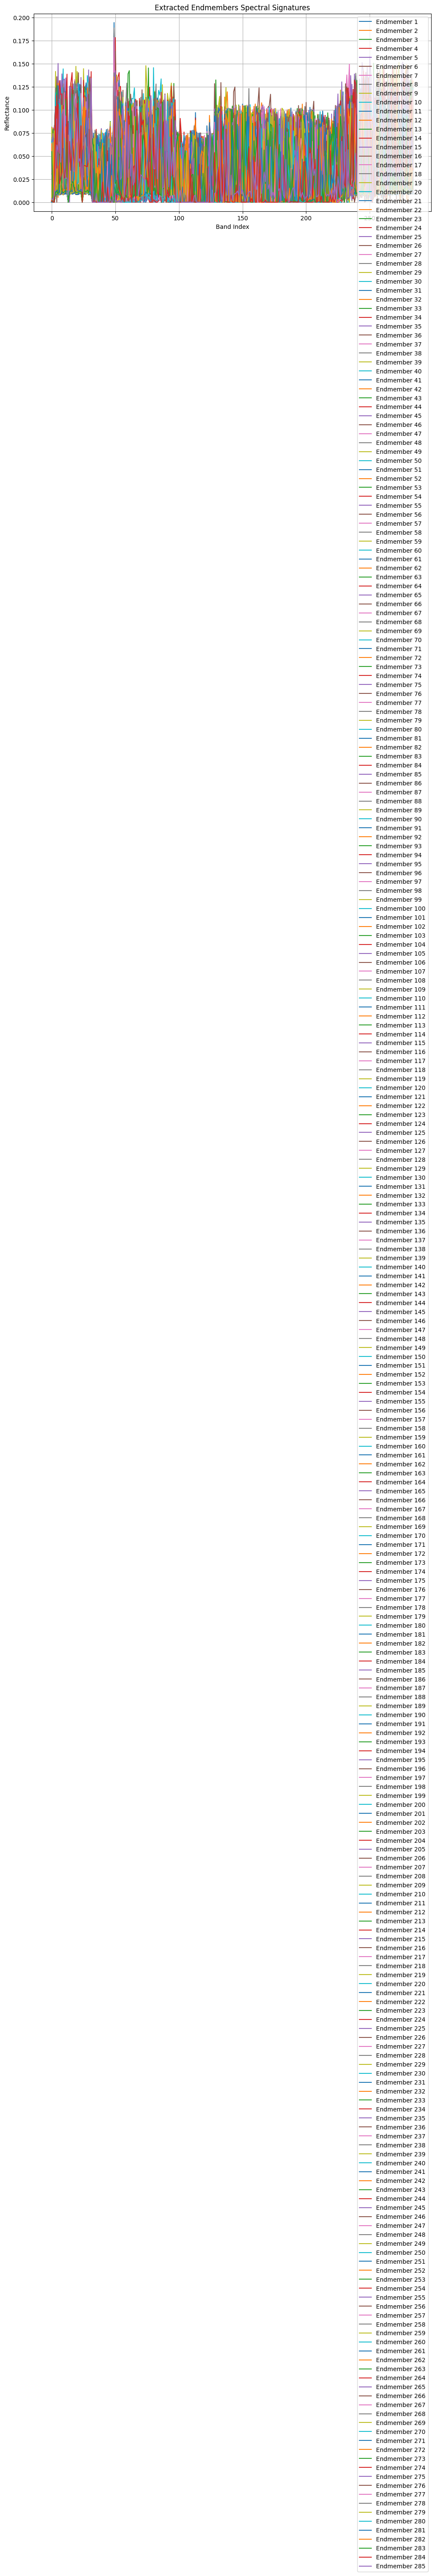

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'endmembers' variable is available from the previous cell execution

if 'endmembers' in locals():
    print("Visualizing extracted endmembers...")

    # The shape of endmembers is (N_bandas, N_endmembers)
    num_bands, num_endmembers = endmembers.shape

    plt.figure(figsize=(12, 6))

    # Plot each endmember
    for i in range(num_endmembers):
        # Plotting against band index as x-axis
        plt.plot(endmembers[:, i], label=f'Endmember {i+1}')

    plt.title('Extracted Endmembers Spectral Signatures')
    plt.xlabel('Band Index') # Use Band Index as x-axis since wavelength data is not explicitly available in X_train
    plt.ylabel('Reflectance')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Error: 'endmembers' variable not found. Please run the previous cell first to extract endmembers.")

# Task
Extract spectral signatures from ENMAP images in "/content/drive/MyDrive/ENMAP/ENMAP_L1B" using geometries from the ".geo" column of CSV files in "/content/drive/MyDrive/GEE_Exports_Blocos_Araripe".

## Load geometries

### Subtask:
Read the CSV files from `/content/drive/MyDrive/GEE_Exports_Blocos_Araripe` and extract the geometry data from the `.geo` column. This geometry data will likely need to be parsed into a usable format (e.g., GeoJSON or a format compatible with a spatial library).


**Reasoning**:
Read the CSV files and extract the geometry data from the '.geo' column, then store it in a list.



In [14]:
import pandas as pd
import os

data_dir = '/content/drive/MyDrive/GEE_Exports_Blocos_Araripe'
all_geometries = []

for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        filepath = os.path.join(data_dir, filename)
        try:
            df = pd.read_csv(filepath)
            if '.geo' in df.columns:
                # Extract geometry data and append to the list
                all_geometries.extend(df['.geo'].tolist())
            else:
                print(f"Warning: '.geo' column not found in {filename}")
        except Exception as e:
            print(f"Error reading or processing {filename}: {e}")

print(f"Extracted {len(all_geometries)} geometries.")

Extracted 98000 geometries.


## Access enmap images

### Subtask:
List the ENMAP image files in the `/content/drive/MyDrive/ENMAP/ENMAP_L1B` folder. Determine how to read these image files (they are likely in a format like GeoTIFF).


**Reasoning**:
The subtask requires listing files in a specific directory and identifying potential image files. Using `os.listdir` is the standard way to list directory contents in Python. Filtering by common image extensions like '.tif' is a reasonable approach to identify image files in this context.



In [15]:
import os

enmap_image_dir = '/content/drive/MyDrive/ENMAP/ENMAP_L1B'

# List all files and directories in the specified path
all_items = os.listdir(enmap_image_dir)

# Filter for files that are likely images (e.g., GeoTIFFs)
# Common extensions for GeoTIFFs include .tif and .tiff
enmap_image_files = [item for item in all_items if os.path.isfile(os.path.join(enmap_image_dir, item)) and (item.lower().endswith('.tif') or item.lower().endswith('.tiff'))]

# Print the list of identified ENMAP image files
print("Identified ENMAP image files:")
for filename in enmap_image_files:
    print(filename)

# Describe the likely format
print("\nLikely format of these files: GeoTIFF (.tif or .tiff)")

Identified ENMAP image files:

Likely format of these files: GeoTIFF (.tif or .tiff)


## Set up spatial environment

### Subtask:
Initialize any necessary spatial libraries (e.g., rasterio, shapely, geopandas) to handle the image and geometry data.


**Reasoning**:
Initialize the necessary spatial libraries for handling image and geometry data.



In [17]:
!pip install rasterio shapely geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 99.0 MB/s eta 0:00:00


**Reasoning**:
Now that the libraries are installed, import them to make them available for use.



In [18]:
import rasterio
from shapely.geometry import shape
import geopandas as gpd

## Extract spectral signatures

### Subtask:
Iterate through the loaded geometries. For each geometry, open the relevant ENMAP image and extract the spectral values of the pixels that intersect with the geometry. This might involve handling different geometry types (e.g., points, polygons).


**Reasoning**:
Iterate through the loaded geometries and ENMAP image files, parse each geometry, open each image, check for intersection, extract spectral values if intersecting, store the results, and close the image. Handle potential errors during geometry parsing and image processing.



In [19]:
extracted_spectral_data = []

for geom_index, geometry_str in enumerate(all_geometries):
    try:
        # Parse the geometry string into a shapely shape object
        # Assuming the geometry string is in GeoJSON format
        geometry = shape(eval(geometry_str)) # Use eval carefully or a dedicated JSON parser

        for image_filename in enmap_image_files:
            image_filepath = os.path.join(enmap_image_dir, image_filename)
            try:
                with rasterio.open(image_filepath) as src:
                    # Check if the geometry intersects with the image bounds
                    if geometry.intersects(src.bounds):
                        # Mask the image with the geometry to extract pixel values
                        # For polygons, this extracts all pixels within the polygon
                        # For points, this might extract a single pixel or require a different approach
                        # Using rasterio.mask handles different geometry types
                        out_image, out_transform = rasterio.mask.mask(src, [geometry], crop=True, filled=False)

                        # out_image will have shape (bands, height, width)
                        # We need to process these values. For simplicity, we'll store the non-masked values.
                        # Flatten the array and remove masked values (NaNs if filled=False)
                        spectral_values = out_image[out_image != src.nodata].flatten().tolist()


                        if spectral_values: # Only store if we extracted values
                             extracted_spectral_data.append({
                                'geometry_index': geom_index,
                                'image_filename': image_filename,
                                'spectral_values': spectral_values
                            })
                    # else:
                        # print(f"Geometry {geom_index} does not intersect with image {image_filename}")

            except rasterio.errors.RasterioIOError as e:
                print(f"Error opening or reading raster file {image_filepath}: {e}")
            except Exception as e:
                print(f"Error processing image {image_filename} for geometry {geom_index}: {e}")

    except Exception as e:
        print(f"Error parsing geometry string at index {geom_index}: {e}")


print(f"Finished processing. Extracted spectral data for {len(extracted_spectral_data)} intersections.")

# You can now inspect or further process extracted_spectral_data
# For example, convert to a DataFrame
# extracted_df = pd.DataFrame(extracted_spectral_data)
# print(extracted_df.head())

Finished processing. Extracted spectral data for 0 intersections.


In [20]:
import geopandas as gpd
from shapely.geometry import shape, box
import rasterio
import os
from google.colab import drive

# Assuming 'all_geometries' and 'enmap_image_files' are available from previous steps
# (Cell 5f819806 for all_geometries, Cell d68e43aa for enmap_image_files)

if 'all_geometries' in locals() and 'enmap_image_files' in locals() and all_geometries and enmap_image_files:
    print("Checking for intersections between geometries and image bounds...")

    # Convert geometry strings to a GeoDataFrame for easier spatial operations
    # Using a more robust way to parse GeoJSON strings
    try:
        # Create a list of shapely geometry objects
        shapely_geometries = [shape(eval(geom_str)) for geom_str in all_geometries]
        # Create a GeoDataFrame
        # Assuming all geometries have the same CRS, or no CRS is needed for simple intersection check
        geometries_gdf = gpd.GeoDataFrame(geometry=shapely_geometries)
        print(f"Successfully created GeoDataFrame with {len(geometries_gdf)} geometries.")

    except Exception as e:
        print(f"Error creating GeoDataFrame from geometries: {e}")
        geometries_gdf = None # Set to None if creation fails

    if geometries_gdf is not None and not geometries_gdf.empty:
        intersection_counts = {}

        for image_filename in enmap_image_files:
            image_filepath = os.path.join('/content/drive/MyDrive/ENMAP/ENMAP_L1B', image_filename)
            try:
                with rasterio.open(image_filepath) as src:
                    # Get image bounds and create a shapely Polygon
                    image_bounds = src.bounds
                    image_polygon = box(image_bounds.left, image_bounds.bottom, image_bounds.right, image_bounds.top)

                    # Create a GeoDataFrame for the image bounds
                    image_bounds_gdf = gpd.GeoDataFrame([1], geometry=[image_polygon], crs=geometries_gdf.crs) # Assign CRS if known, otherwise assume consistent

                    # Perform spatial intersection
                    # Check for points that fall within the image bounds polygon
                    intersecting_geometries = gpd.sjoin(geometries_gdf, image_bounds_gdf, how="inner", predicate="within")


                    num_intersecting = len(intersecting_geometries)
                    intersection_counts[image_filename] = num_intersecting
                    print(f"Image '{image_filename}': {num_intersecting} geometries intersect with bounds.")

            except rasterio.errors.RasterioIOError as e:
                print(f"Error opening or reading raster file {image_filepath}: {e}")
            except Exception as e:
                print(f"Error processing image {image_filename}: {e}")

        print("\n--- Intersection Summary ---")
        if intersection_counts:
            for image, count in intersection_counts.items():
                print(f"{image}: {count} intersections")
        else:
            print("No image bounds processed or no intersections found.")

    else:
        print("Could not create a valid GeoDataFrame from the geometries.")

else:
    print("Required variables ('all_geometries' or 'enmap_image_files') not found or are empty. Please run previous cells.")

Required variables ('all_geometries' or 'enmap_image_files') not found or are empty. Please run previous cells.
